In [1]:
# Installing EfficientNet
!pip3 install efficientnet_pytorch

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [42]:
# Installing required dependencies 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from collections import OrderedDict
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from efficientnet_pytorch import EfficientNet
from torchsampler import ImbalancedDatasetSampler
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
from tqdm import tqdm
plt.ion() 

In [43]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomCrop((256, 256), pad_if_needed=True),
        transforms.RandomAffine(10),
        transforms.RandomHorizontalFlip(p=0.5),
#         transforms.RandomVerticalFlip(p=0.5),
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#         transforms.RandomGrayscale(p=0.5),
        transforms.RandomRotation(10),
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                              sampler=ImbalancedDatasetSampler(image_datasets[x]),
                                              num_workers=10)
              for x in ['train', 'validation']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

print(class_names)
print(len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
7


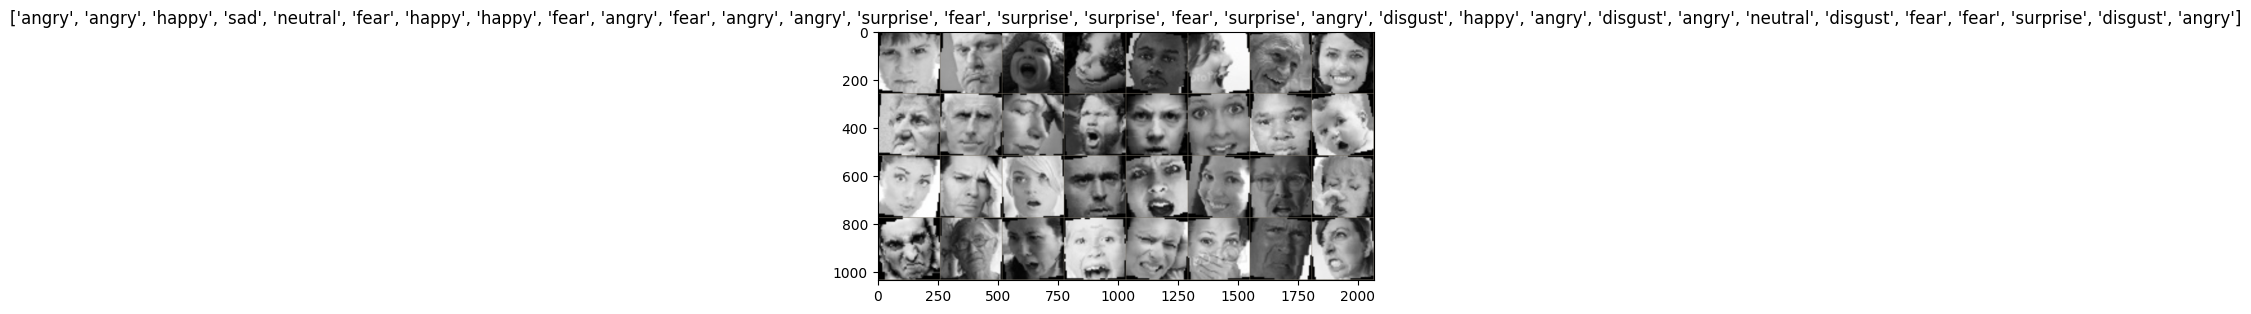

In [44]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [45]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            with tqdm(dataloaders[phase], unit="batch") as tepoch:
                for inputs, labels in tepoch:
                    tepoch.set_description(f"Epoch {epoch}")
                    inputs = inputs.to(device)
                    labels = labels.to(device)


                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [46]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # print(labels)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [47]:
# model_ft = models.resnet18(pretrained=True)
model_ft = EfficientNet.from_pretrained('efficientnet-b0')
# print(model_ft)

num_ftrs = model_ft._fc.in_features
# model_ft._fc = nn.Linear(num_ftrs, 7)
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1280,512)),
    ('relu', nn.ReLU()),
    ('dropout', nn.Dropout(0.4)),
    ('fc2', nn.Linear(512,7))
#     ('output', nn.Softmax(dim=1))
]))
model_ft._fc = fc
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft =  optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)
optimizer_ft = optim.AdamW(model_ft.parameters(),lr=0.0001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Loaded pretrained weights for efficientnet-b0


In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


Epoch 0: 100%|██████████| 901/901 [01:50<00:00,  8.14batch/s]


train Loss: 1.3662 Acc: 0.4767


Epoch 0: 100%|██████████| 221/221 [00:09<00:00, 23.03batch/s]


validation Loss: 1.0915 Acc: 0.5952

Epoch 1/14
----------


Epoch 1: 100%|██████████| 901/901 [01:42<00:00,  8.78batch/s]


train Loss: 0.9924 Acc: 0.6249


Epoch 1: 100%|██████████| 221/221 [00:09<00:00, 22.92batch/s]


validation Loss: 1.0479 Acc: 0.6288

Epoch 2/14
----------


Epoch 2: 100%|██████████| 901/901 [01:41<00:00,  8.86batch/s]


train Loss: 0.8880 Acc: 0.6651


Epoch 2: 100%|██████████| 221/221 [00:09<00:00, 24.06batch/s]


validation Loss: 1.0098 Acc: 0.6485

Epoch 3/14
----------


Epoch 3: 100%|██████████| 901/901 [01:44<00:00,  8.66batch/s]


train Loss: 0.8172 Acc: 0.6929


Epoch 3: 100%|██████████| 221/221 [00:08<00:00, 24.65batch/s]


validation Loss: 1.0648 Acc: 0.6555

Epoch 4/14
----------


Epoch 4: 100%|██████████| 901/901 [01:40<00:00,  8.99batch/s]


train Loss: 0.7632 Acc: 0.7152


Epoch 4: 100%|██████████| 221/221 [00:09<00:00, 24.20batch/s]


validation Loss: 0.9783 Acc: 0.6673

Epoch 5/14
----------


Epoch 5: 100%|██████████| 901/901 [01:44<00:00,  8.66batch/s]


train Loss: 0.7102 Acc: 0.7350


Epoch 5: 100%|██████████| 221/221 [00:10<00:00, 21.85batch/s]


validation Loss: 1.0297 Acc: 0.6698

Epoch 6/14
----------


Epoch 6: 100%|██████████| 901/901 [01:43<00:00,  8.69batch/s]


train Loss: 0.6669 Acc: 0.7526


Epoch 6: 100%|██████████| 221/221 [00:08<00:00, 24.92batch/s]


validation Loss: 1.0756 Acc: 0.6786

Epoch 7/14
----------


Epoch 7: 100%|██████████| 901/901 [01:39<00:00,  9.02batch/s]


train Loss: 0.6095 Acc: 0.7737


Epoch 7: 100%|██████████| 221/221 [00:09<00:00, 24.31batch/s]


validation Loss: 1.0392 Acc: 0.6821

Epoch 8/14
----------


Epoch 8: 100%|██████████| 901/901 [01:44<00:00,  8.63batch/s]


train Loss: 0.5941 Acc: 0.7818


Epoch 8: 100%|██████████| 221/221 [00:09<00:00, 23.50batch/s]


validation Loss: 1.0350 Acc: 0.6911

Epoch 9/14
----------


Epoch 9: 100%|██████████| 901/901 [01:45<00:00,  8.58batch/s]


train Loss: 0.5863 Acc: 0.7852


Epoch 9: 100%|██████████| 221/221 [00:09<00:00, 23.18batch/s]


validation Loss: 1.0470 Acc: 0.6902

Epoch 10/14
----------


Epoch 10: 100%|██████████| 901/901 [01:48<00:00,  8.33batch/s]


train Loss: 0.5629 Acc: 0.7911


Epoch 10: 100%|██████████| 221/221 [00:10<00:00, 21.68batch/s]


validation Loss: 0.9958 Acc: 0.6932

Epoch 11/14
----------


Epoch 11: 100%|██████████| 901/901 [01:48<00:00,  8.29batch/s]


train Loss: 0.5582 Acc: 0.7951


Epoch 11: 100%|██████████| 221/221 [00:09<00:00, 22.79batch/s]


validation Loss: 1.0309 Acc: 0.6916

Epoch 12/14
----------


Epoch 12: 100%|██████████| 901/901 [01:47<00:00,  8.36batch/s]


train Loss: 0.5471 Acc: 0.7991


Epoch 12: 100%|██████████| 221/221 [00:10<00:00, 21.08batch/s]


validation Loss: 1.0347 Acc: 0.6970

Epoch 13/14
----------


Epoch 13: 100%|██████████| 901/901 [01:51<00:00,  8.11batch/s]


train Loss: 0.5397 Acc: 0.8004


Epoch 13: 100%|██████████| 221/221 [00:10<00:00, 21.10batch/s]


validation Loss: 1.1246 Acc: 0.6786

Epoch 14/14
----------


Epoch 14: 100%|██████████| 901/901 [01:50<00:00,  8.16batch/s]


train Loss: 0.5365 Acc: 0.8008


Epoch 14: 100%|██████████| 221/221 [00:10<00:00, 21.76batch/s]


validation Loss: 1.0814 Acc: 0.6929

Training complete in 28m 47s
Best val Acc: 0.000000


In [50]:
PATH = '../artifacts/efficientnet_emotion.pt'
torch.save(model_ft.state_dict(), PATH)

In [ ]:
torch.cuda.empty_cache()